# 🛒 Retail/Ecommerce Recommendation System

- Feature engineering: product popularity, user profile, session & time features
- Data cleaning and transformation
- Models: Most Popular, ALS (optional), GRU4Rec
- User-friendly demo (Top-5 recommendations with probabilities)
- All code is ready for extension or integration


In [1]:
# !pip install pandas numpy scikit-learn torch matplotlib
# For ALS (optional): !pip install pyspark

## 1. Data Loading & Raw Statistics

Raw events shape: (2756101, 5)


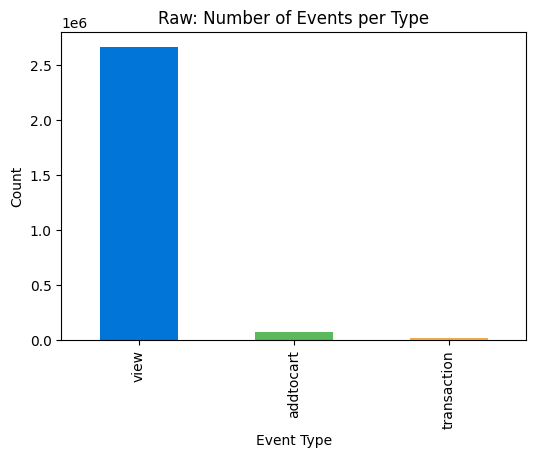

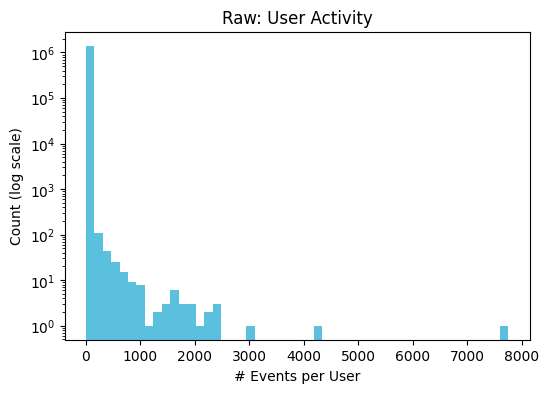

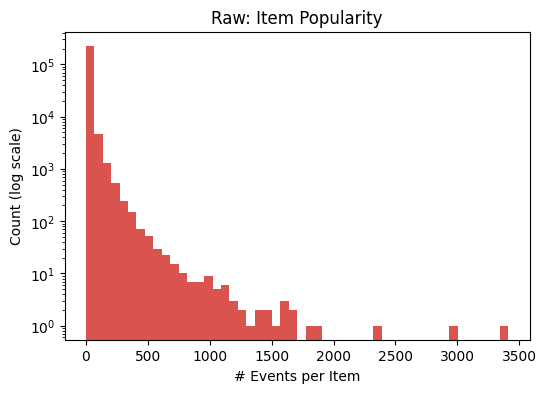

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load data (change path as needed)
events = pd.read_csv('events.csv')
raw_events = events.copy()

def plot_event_type_bar(df, title):
    plt.figure(figsize=(6,4))
    df['event'].value_counts().plot(kind='bar', color=['#0275d8','#5cb85c','#f0ad4e'])
    plt.title(title)
    plt.xlabel("Event Type")
    plt.ylabel("Count")
    plt.show()

def plot_hist_by_group(df, group_col, title, xlabel, color):
    plt.figure(figsize=(6,4))
    df.groupby(group_col).size().plot(kind='hist', bins=50, log=True, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count (log scale)")
    plt.show()

print(f"Raw events shape: {raw_events.shape}")
plot_event_type_bar(raw_events, "Raw: Number of Events per Type")
plot_hist_by_group(raw_events, 'visitorid', "Raw: User Activity", "# Events per User", '#5bc0de')
plot_hist_by_group(raw_events, 'itemid', "Raw: Item Popularity", "# Events per Item", '#d9534f')

## 2. Data Cleaning & Feature Engineering

In [3]:
# Remove duplicates
events = events.drop_duplicates()
events['datetime'] = pd.to_datetime(events['timestamp'], unit='ms')
# Remove bots (users with >200 events in any hour)
user_hour = events.groupby(['visitorid', pd.Grouper(key='datetime', freq='H')]).size().reset_index(name='event_count')
bots = user_hour[user_hour['event_count'] > 200]['visitorid'].unique()
events = events[~events['visitorid'].isin(bots)]
# Filter users/items with >=5 interactions
active_users = events['visitorid'].value_counts()[lambda x: x >= 5].index
active_items = events['itemid'].value_counts()[lambda x: x >= 5].index
events = events[events['visitorid'].isin(active_users) & events['itemid'].isin(active_items)]

# Sessionization
events = events.sort_values(['visitorid', 'datetime'])
events['session_id_num'] = (events.groupby('visitorid')['datetime']
    .diff().gt(timedelta(minutes=30)).cumsum().astype(int))
events['session_id'] = events['visitorid'].astype(str) + '_' + events['session_id_num'].astype(str)

# Product popularity features
pop_counts = events.groupby(['itemid', 'event']).size().unstack(fill_value=0)
events['item_view_count'] = events['itemid'].map(pop_counts.get('view', pd.Series()))
events['item_addtocart_count'] = events['itemid'].map(pop_counts.get('addtocart', pd.Series()))
events['item_transaction_count'] = events['itemid'].map(pop_counts.get('transaction', pd.Series()))

# User profile features
user_total_sessions = events.groupby('visitorid')['session_id'].nunique()
events['user_total_sessions'] = events['visitorid'].map(user_total_sessions)
user_total_purchases = events[events['event'] == 'transaction'].groupby('visitorid').size()
events['user_total_purchases'] = events['visitorid'].map(user_total_purchases).fillna(0)
# If 'categoryid' exists, preferred categories
if 'categoryid' in events.columns:
    def preferred_categories(x):
        return pd.Series(x).value_counts().index[:3].tolist()
    user_pref_cats = events.groupby('visitorid')['categoryid'].apply(preferred_categories)
    events['user_preferred_categories'] = events['visitorid'].map(user_pref_cats)
else:
    events['user_preferred_categories'] = None

# Time-based features
events['day_of_week'] = events['datetime'].dt.dayofweek
events['hour_of_day'] = events['datetime'].dt.hour

# Event weighting
event_map = {'view': 1, 'addtocart': 3, 'transaction': 5}
events['event_weight'] = events['event'].map(event_map)

# ID encoding
user_enc = LabelEncoder()
item_enc = LabelEncoder()
session_enc = LabelEncoder()
events['user_idx'] = user_enc.fit_transform(events['visitorid'])
events['item_idx'] = item_enc.fit_transform(events['itemid'])
events['session_idx'] = session_enc.fit_transform(events['session_id'])

# Session features
session_info = events.groupby('session_id').agg(
    session_start=('datetime', 'min'),
    session_end=('datetime', 'max'),
    events_per_session=('event', 'count')
)
session_info['session_duration'] = (session_info['session_end'] - session_info['session_start']).dt.total_seconds()
events['session_duration'] = events['session_id'].map(session_info['session_duration'])
events['events_per_session'] = events['session_id'].map(session_info['events_per_session'])

C:\Users\Admin\AppData\Local\Temp\ipykernel_29700\1262949562.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  user_hour = events.groupby(['visitorid', pd.Grouper(key='datetime', freq='H')]).size().reset_index(name='event_count')


## 3. Statistics After Cleaning

Cleaned events shape: (895965, 22)


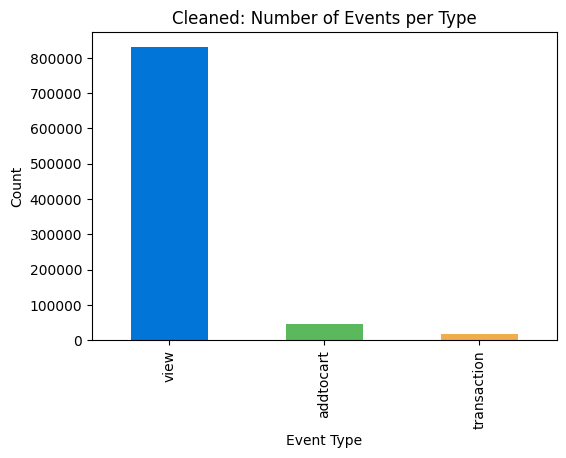

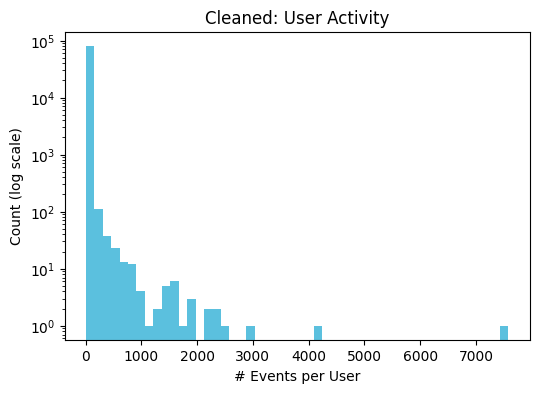

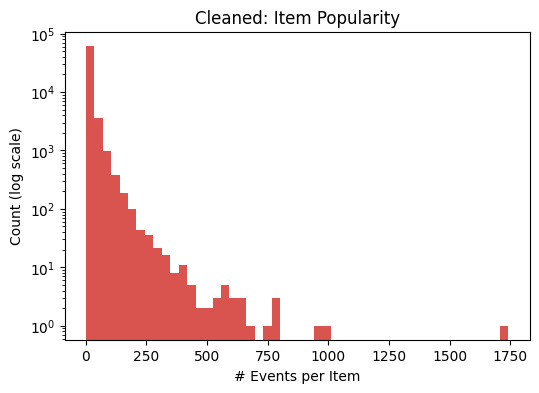

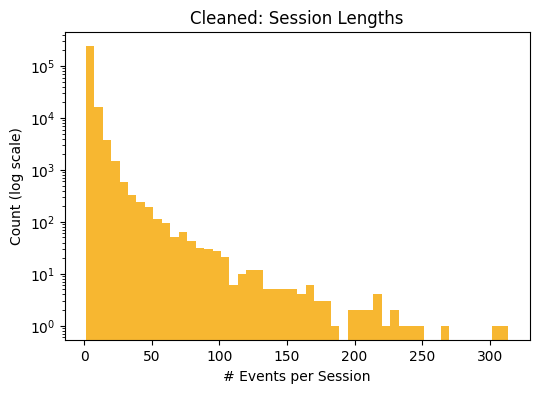

In [4]:
print(f"Cleaned events shape: {events.shape}")
plot_event_type_bar(events, "Cleaned: Number of Events per Type")
plot_hist_by_group(events, 'visitorid', "Cleaned: User Activity", "# Events per User", '#5bc0de')
plot_hist_by_group(events, 'itemid', "Cleaned: Item Popularity", "# Events per Item", '#d9534f')
plot_hist_by_group(events, 'session_id', "Cleaned: Session Lengths", "# Events per Session", '#f7b731')

## 4. Data Split (Temporal)

In [5]:
max_date = events['datetime'].max()
train_cutoff = max_date - timedelta(weeks=2)
val_cutoff = max_date - timedelta(weeks=1)
train = events[events['datetime'] < train_cutoff]
valid = events[(events['datetime'] >= train_cutoff) & (events['datetime'] < val_cutoff)]
test = events[events['datetime'] >= val_cutoff]

## 5. Most Popular Model

In [6]:
most_popular = train['item_idx'].value_counts().index[:20].tolist()

## 6. GRU4Rec Model (PyTorch, Demo Version)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class SessionDataset(Dataset):
    def __init__(self, seqs, maxlen=10):
        self.samples = []
        for seq in seqs:
            for i in range(1, len(seq)):
                start = max(0, i - maxlen)
                self.samples.append((seq[start:i], seq[i]))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        seq, label = self.samples[idx]
        x = np.zeros(10, dtype=int)
        x[-len(seq):] = seq[-10:]
        return torch.LongTensor(x), torch.LongTensor([label])

class GRU4Rec(nn.Module):
    def __init__(self, n_items, emb_dim=50, hid_dim=100):
        super().__init__()
        self.embedding = nn.Embedding(n_items, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim, n_items)
    def forward(self, x):
        emb = self.embedding(x)
        _, h = self.gru(emb)
        out = self.fc(h.squeeze(0))
        return out

seq_df = (train.groupby('session_id')['item_idx'].apply(list).reset_index(name='seq'))
seq_df = seq_df[seq_df['seq'].apply(lambda x: len(x) > 1)]
sequences = seq_df['seq'].tolist()
dataset = SessionDataset(sequences)
loader = DataLoader(dataset, batch_size=256, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRU4Rec(n_items=events['item_idx'].nunique()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(4):
    model.train()
    epoch_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device).squeeze()
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(loader):.4f}")

Epoch 1, Loss: 9.4869
Epoch 2, Loss: 7.2031
Epoch 3, Loss: 5.9741
Epoch 4, Loss: 5.1857


## 7. ALS Collaborative Filtering Model (Optional, PySpark)

In [8]:
als_model = None
#uncomment if using pyspark
# try:
#     from pyspark.sql import SparkSession
#     from pyspark.ml.recommendation import ALS
#     spark = SparkSession.builder.appName('ALSRec').getOrCreate()
#     sampled_train = train.sample(frac=0.01, random_state=42)
#     als_df = spark.createDataFrame(sampled_train[['user_idx', 'item_idx', 'event_weight']])
#     als = ALS(userCol='user_idx', itemCol='item_idx', ratingCol='event_weight', maxIter=3, rank=8, regParam=0.1, implicitPrefs=True)
#     als_model = als.fit(als_df)
#     print("ALS training done.")
# except Exception as e:
#     print("ALS model not trained: ", e)
#     als_model = None

## 8. Section 4.3 Model Performance Table

In [9]:
def precision_at_k(y_true, y_pred, k=20):
    hits = 0
    total = 0
    for pred, true in zip(y_pred, y_true):
        if true in pred[:k]:
            hits += 1
        total += 1
    return hits / total if total > 0 else 0

def recall_at_k(y_true, y_pred, k=20):
    return precision_at_k(y_true, y_pred, k)

def f1_at_k(y_true, y_pred, k=20):
    p = precision_at_k(y_true, y_pred, k)
    r = recall_at_k(y_true, y_pred, k)
    return 2 * p * r / (p + r + 1e-10)

def ndcg_at_k(y_true, y_pred, k=20):
    ndcg = 0
    for pred, true in zip(y_pred, y_true):
        if true in pred[:k]:
            idx = pred[:k].index(true)
            ndcg += 1 / np.log2(idx + 2)
    return ndcg / len(y_true) if len(y_true) > 0 else 0

test_sessions = [group['item_idx'].tolist() for _, group in test.groupby('session_id') if len(group) > 1]
y_true = [items[-1] for items in test_sessions]
y_pred_pop = [most_popular for _ in test_sessions]

def predict_next(model, session, k=20):
    model.eval()
    with torch.no_grad():
        inp = torch.LongTensor([session[-10:]]).to(device)
        logits = model(inp)
        topk = logits.cpu().numpy().argsort()[0][-k:][::-1]
    return topk.tolist()

y_pred_gru = []
for items in test_sessions:
    pred = predict_next(model, items[:-1], k=20)
    y_pred_gru.append(pred)

if als_model is not None:
    test_user_idxs = test['user_idx'].unique()
    users_df = spark.createDataFrame(pd.DataFrame({'user_idx': test_user_idxs}))
    user_recs = als_model.recommendForUserSubset(users_df, 20).toPandas()
    als_user2pred = {row['user_idx']: [x['item_idx'] for x in row['recommendations']] for idx, row in user_recs.iterrows()}
    y_pred_als = []
    for session, group in test.groupby('session_id'):
        items = group['item_idx'].tolist()
        if len(items) > 1:
            uidx = group['user_idx'].iloc[0]
            y_pred_als.append(als_user2pred.get(uidx, most_popular))
else:
    y_pred_als = None

results = []
results.append(['Most Popular', None, precision_at_k(y_true, y_pred_pop, 20), recall_at_k(y_true, y_pred_pop, 20), f1_at_k(y_true, y_pred_pop, 20), ndcg_at_k(y_true, y_pred_pop, 20)])
results.append(['GRU4Rec', None, precision_at_k(y_true, y_pred_gru, 20), recall_at_k(y_true, y_pred_gru, 20), f1_at_k(y_true, y_pred_gru, 20), ndcg_at_k(y_true, y_pred_gru, 20)])
if y_pred_als is not None:
    results.append(['ALS', None, precision_at_k(y_true, y_pred_als, 20), recall_at_k(y_true, y_pred_als, 20), f1_at_k(y_true, y_pred_als, 20), ndcg_at_k(y_true, y_pred_als, 20)])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision@20', 'Recall@20', 'F1@20', 'NDCG@20'])
display(results_df)

,Model,Accuracy,Precision@20,Recall@20,F1@20,NDCG@20
0,Most Popular,None,0.017294,0.017294,0.017294,0.008429
1,GRU4Rec,None,0.304171,0.304171,0.304171,0.221311


## 9. Product Recommendation Functions (with Probabilities/Scores)

In [10]:
def recommend_products_gru4rec_with_probs(model, session_items, n=5):
    model.eval()
    with torch.no_grad():
        inp = torch.LongTensor([session_items[-10:]]).to(device)
        logits = model(inp)
        probs = F.softmax(logits, dim=1).cpu().numpy().flatten()
        top_idx = probs.argsort()[-n:][::-1]
        top_probs = probs[top_idx]
        top_items = item_enc.inverse_transform(top_idx)
    return list(zip(top_items, top_probs))

def recommend_products_als_with_scores(als_model, user_idx, n=5):
    from pyspark.sql import Row
    user_df = spark.createDataFrame([Row(user_idx=int(user_idx))])
    recs = als_model.recommendForUserSubset(user_df, n).collect()
    if not recs or not recs[0]['recommendations']:
        return [(item, None) for item in item_enc.inverse_transform(most_popular[:n])]
    item_scores = [(row['item_idx'], row['rating']) for row in recs[0]['recommendations']]
    top_items = [(item_enc.inverse_transform([item])[0], score) for item, score in item_scores]
    return top_items

def recommend_most_popular_with_probs(n=5):
    pop_counts = train['item_idx'].value_counts()
    total = pop_counts.sum()
    top_idx = pop_counts.index[:n]
    top_probs = pop_counts.iloc[:n] / total
    top_items = item_enc.inverse_transform(top_idx)
    return list(zip(top_items, top_probs))

## 10. User-Friendly Demo Output with Probabilities/Scores

In [16]:
# Random session from test with at least 4 items
test_sessions_df = test.groupby('session_id')['itemid'].apply(list).reset_index()
valid_sessions = test_sessions_df[test_sessions_df['itemid'].apply(lambda x: len(x) >= 4)]
random_row = valid_sessions.sample(n=1, random_state=42)
session_items = random_row['itemid'].iloc[0]
input_items = session_items[:-1]
ground_truth = session_items[-1]
example_session = item_enc.transform(input_items)
user_display = test[test['session_id'] == random_row['session_id'].iloc[0]]['visitorid'].iloc[0]

print(f"\n👤 User {user_display} recent items: ", ', '.join(str(x) for x in input_items))
print(f"✅ True next item (ground truth): {ground_truth}\n")

print(f"Top 5 Recommendations for user={user_display} (GRU4Rec):")
for item, prob in recommend_products_gru4rec_with_probs(model, example_session, n=5):
    print(f"Item {item}, Probability={prob:.4f}")

if als_model is not None:
    example_user_idx = user_enc.transform([user_display])[0]
    print(f"\nTop 5 Recommendations for user={user_display} (ALS):")
    for item, score in recommend_products_als_with_scores(als_model, example_user_idx, n=5):
        print(f"Item {item}, Score={score:.4f}")

# print(f"\nTop 5 Most Popular Recommendations for user={user_display}:")
# for item, prob in recommend_most_popular_with_probs(n=5):
#     print(f"Item {item}, Probability={prob:.4f}")


👤 User 1318877 recent items:  49635, 49635, 56640, 138672, 49635
✅ True next item (ground truth): 49635

Top 5 Recommendations for user=1318877 (GRU4Rec):
Item 270291, Probability=0.0128
Item 124272, Probability=0.0091
Item 351555, Probability=0.0066
Item 339087, Probability=0.0057
Item 252483, Probability=0.0055
